In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pylab', 'rc', 'colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [19]:
import pylab
pylab.rcParams['xtick.major.pad']='8'
pylab.rcParams['ytick.major.pad']='8'
#pylab.rcParams['font.sans-serif']='Arial'

from matplotlib import rc
rc('font', family='sans-serif')
rc('font', size=10.0)
rc('text', usetex=False)


from matplotlib.font_manager import FontProperties

panel_label_font = FontProperties().copy()
panel_label_font.set_weight("bold")
panel_label_font.set_size(12.0)
panel_label_font.set_family("sans-serif")

archival_sources = ['Metropolitan Opera', 'Opera Scotland', 'Royal Opera House', 'Teatro alla Scala', 'Wiener Staatsoper', 
                    'Chicago Lyric Opera','San Francisco Opera','Czech National Theatre','Glyndebourne','Salzburg Festival',
                    'Sweden Opera House','National Opera de Paris','Opera Comique']
commercial_sources_world = ['bachtrack.com','operabase.com','operacritic.com']
commercial_sources_uk = ['Concert-Diary','U.K. Theatre Web']
government_sources = ['National Central Opera Service Reports', 'Opera America']

colors = ['#8a170f', '#8a540f', '#828a0f', '#458a0f', '#0f8a17', '#0f8a54', '#0f828a', '#0f458a', '#170f8a', '#540f8a', '#8a0f82', '#8a0f45']

import powerlaw

In [11]:
#database connection settings
import psycopg2

db_name = "traviato_development"
db_host = "localhost"
db_port = "5432"
db_user = "lievgarcia"
db_pwd = "traviato81"

conn = psycopg2.connect(database=db_name, user=db_user, password=db_pwd, host=db_host, port=db_port)

In [12]:
def plot_basics(data, data_inst, fig, units):
    from powerlaw import plot_pdf, Fit, pdf
    annotate_coord = (-.4, .95)
    ax1 = fig.add_subplot(n_graphs,n_data,data_inst)
    x, y = pdf(data, linear_bins=True)
    ind = y>0
    y = y[ind]
    x = x[:-1]
    x = x[ind]
    ax1.scatter(x, y, color='r', s=.5)
    plot_pdf(data[data>0], ax=ax1, color='b', linewidth=2)
    from pylab import setp
    setp( ax1.get_xticklabels(), visible=False)

    if data_inst==1:
        ax1.annotate("A", annotate_coord, xycoords="axes fraction", fontproperties=panel_label_font)

    
    from mpl_toolkits.axes_grid.inset_locator import inset_axes
    ax1in = inset_axes(ax1, width = "30%", height = "30%", loc=3)
    ax1in.hist(data, normed=True, color='b')
    ax1in.set_xticks([])
    ax1in.set_yticks([])

    
    ax2 = fig.add_subplot(n_graphs,n_data,n_data+data_inst, sharex=ax1)
    plot_pdf(data, ax=ax2, color='b', linewidth=2)
    fit = Fit(data, xmin=1, discrete=True)
    fit.power_law.plot_pdf(ax=ax2, linestyle=':', color='g')
    p = fit.power_law.pdf()

    ax2.set_xlim(ax1.get_xlim())
    
    fit = Fit(data, discrete=True)
    fit.power_law.plot_pdf(ax=ax2, linestyle='--', color='g')
    from pylab import setp
    setp( ax2.get_xticklabels(), visible=False)

    if data_inst==1:
        ax2.annotate("B", annotate_coord, xycoords="axes fraction", fontproperties=panel_label_font)        
        ax2.set_ylabel(u"p(X)")# (10^n)")
        
    ax3 = fig.add_subplot(n_graphs,n_data,n_data*2+data_inst)#, sharex=ax1)#, sharey=ax2)
    fit.power_law.plot_pdf(ax=ax3, linestyle='--', color='g')
    fit.exponential.plot_pdf(ax=ax3, linestyle='--', color='r')
    fit.plot_pdf(ax=ax3, color='b', linewidth=2)
    
    ax3.set_ylim(ax2.get_ylim())
    ax3.set_xlim(ax1.get_xlim())
    
    if data_inst==1:
        ax3.annotate("C", annotate_coord, xycoords="axes fraction", fontproperties=panel_label_font)

    ax3.set_xlabel(units)

In [13]:
import pandas as pd

columns=['source_id', 'source_name', 'composer', 'work', 'country', 'state', 'city', 'theatre', 
         'date_start', 'date_end', 'premiere_date', 'performance_count', 'composer_country', 'theatre_category']

cursor = conn.cursor()  
query = "SELECT s.id as source_id, " + \
        "       s.name as source_name, " + \
        "       coalesce(c.name, l.composer) as composer, " + \
        "       coalesce(w.name, l.work) as work, " + \
        "       l.country, " + \
        "       l.state, " + \
        "       l.city, " + \
        "       l.theatre, " + \
        "       l.date_start, " + \
        "       l.date_end, " + \
        "       w.premiere_date, " + \
        "       l.performance_count, " + \
        "       c.country as composer_country, " + \
        "       CASE WHEN l.source_id = 1 then 'Professional' when opera_america_name IS NULL THEN 'Amateur' ELSE 'Professional' END as theatre_category " + \
        "from sources s " + \
        "INNER JOIN listings l on s.id = l.source_id " + \
        "LEFT JOIN theatre_mapping tm ON l.theatre = tm.name " + \
        "LEFT JOIN listing_mappers lm ON l.map_key = lm.map_key " + \
        "LEFT JOIN works w ON lm.work_uri = w.uri " + \
        "LEFT JOIN composers c ON w.composer_id = c.id " + \
        "WHERE w.uri != 'W1' " + \
        "ORDER BY s.id DESC, l.country, l.state, l.city"
        
cursor.execute(query)

mdf = pd.DataFrame(cursor.fetchall(), columns=columns)
mdf['year'] = mdf.apply(lambda row: row['date_start'].year, axis=1)
mdf['decade'] = mdf.apply(lambda row: 10*int(row['year']/10), axis=1)
mdf[['premiere_date']] = mdf[['premiere_date']].fillna(value=0)
mdf['work_decade'] = mdf.apply(lambda row: 10*int(row['premiere_date']/10), axis=1)


In [16]:
######################## Archive Sources  ########################
######################## CDF per source ########################

a_df = mdf.copy()
a_df = a_df[a_df['source_name'].isin(archival_sources)]
a_df = a_df.groupby(['composer'])
a_df = a_df.agg({'performance_count': np.sum })
a_df = a_df.reset_index(level=['composer'])
a_df = a_df.sort_values(by=['performance_count'], ascending=False)
a_df = a_df.reset_index() 
a_df = a_df.drop(columns=['index'])
a_df.index += 1
a_df = a_df.reset_index()
a_df = a_df.rename({'index': 'Ranking'}, axis='columns')
a_df.head()
data_archives = a_df['performance_count'].values

######################## WORLD  ########################

w_df = mdf.copy()
w_df = w_df[w_df['source_name'].isin(commercial_sources_world)]
w_df = w_df[w_df['year'] > 2007]
w_df = w_df[['composer', 'work', 'country', 'state', 'city', 'date_start', 'date_end', 'premiere_date', 'performance_count', 'year', 'decade', 'work_decade', 'composer_country']]
w_df = w_df.drop_duplicates()

w_df = w_df.groupby(['composer'])
w_df = w_df.agg({'performance_count': np.sum })
w_df = w_df.reset_index(level=['composer'])
w_df = w_df.sort_values(by=['performance_count'], ascending=False)
w_df = w_df.reset_index() 
w_df = w_df.drop(columns=['index'])
w_df.index += 1
w_df = w_df.reset_index()
w_df = w_df.rename({'index': 'Ranking'}, axis='columns')
w_df.head()
data_world = w_df['performance_count'].values
    
###############################################################

oa_df = mdf.copy()
oa_df = oa_df[oa_df['source_name'] == 'Opera America']
oa_df = oa_df.groupby(['composer'])
oa_df = oa_df.agg({'performance_count': np.sum })
oa_df = oa_df.reset_index(level=['composer'])
oa_df = oa_df.sort_values(by=['performance_count'], ascending=False)
oa_df = oa_df.reset_index() 
oa_df = oa_df.drop(columns=['index'])
oa_df.index += 1
oa_df = oa_df.reset_index()
oa_df = oa_df.rename({'index': 'Ranking'}, axis='columns')
oa_df.head()
data_us = oa_df['performance_count'].values
    
###############################################################

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


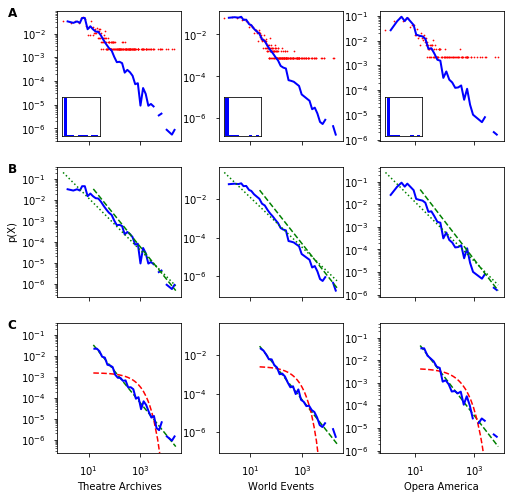

In [20]:
n_data = 3
n_graphs = 4
f = figure(figsize=(8,11))

data = data_archives
data_inst = 1
units = 'Theatre Archives'
plot_basics(data, data_inst, f, units)

data_inst = 2
data = data_world
units = 'World Events'
plot_basics(data, data_inst, f, units)

data = data_us
data_inst = 3
units = 'Opera America'
plot_basics(data, data_inst, f, units)

f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.3, hspace=.2)
figname = 'composer_popularity'
f.savefig(figname+'.eps', bbox_inches='tight')
#f.savefig(figname+'.tiff', bbox_inches='tight', dpi=300)

Calculating best minimal value for power law fit
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


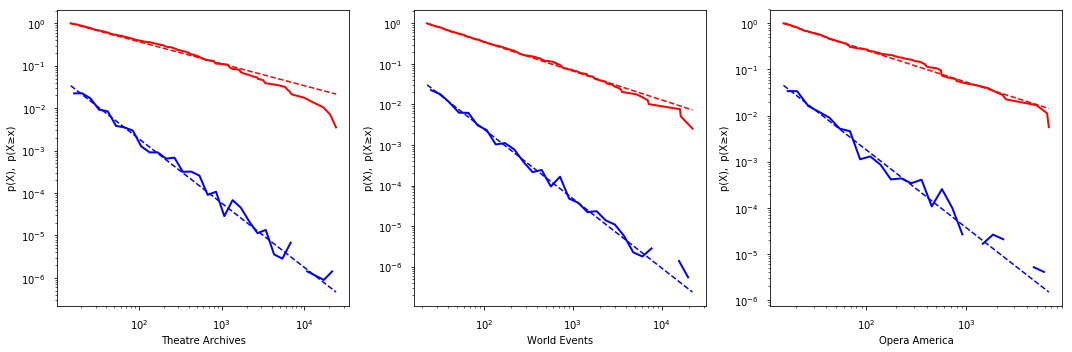

In [21]:
fig = plt.figure(figsize=(15, 5))

data = data_archives
fit = powerlaw.Fit(data, discrete=True)

plt.subplot(1, 3, 1)
figCCDF = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='b', linestyle='--', ax=figCCDF)
fit.plot_ccdf(color='r', linewidth=2, ax=figCCDF)
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=figCCDF)
figCCDF.set_ylabel(u"p(X),  p(X≥x)")
figCCDF.set_xlabel(r"Theatre Archives")

data = data_world
fit = powerlaw.Fit(data, discrete=True)

plt.subplot(1, 3, 2)
figCCDF = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='b', linestyle='--', ax=figCCDF)
fit.plot_ccdf(color='r', linewidth=2, ax=figCCDF)
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=figCCDF)
figCCDF.set_ylabel(u"p(X),  p(X≥x)")
figCCDF.set_xlabel(r"World Events")

data = data_us
fit = powerlaw.Fit(data, discrete=True)

plt.subplot(1, 3, 3)
figCCDF = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='b', linestyle='--', ax=figCCDF)
fit.plot_ccdf(color='r', linewidth=2, ax=figCCDF)
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=figCCDF)
figCCDF.set_ylabel(u"p(X),  p(X≥x)")
figCCDF.set_xlabel(r"Opera America")

plt.tight_layout()

figname = 'composer_ccdf'
savefig(figname+'.eps', bbox_inches='tight')

Calculating best minimal value for power law fit
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/powerlaw.py:1185: RuntimeWarning: divide by zero encountered in double_scalars
  C = 1.0/C
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/optimize.py:543: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/powerlaw.py:830: RuntimeWarning: invalid val

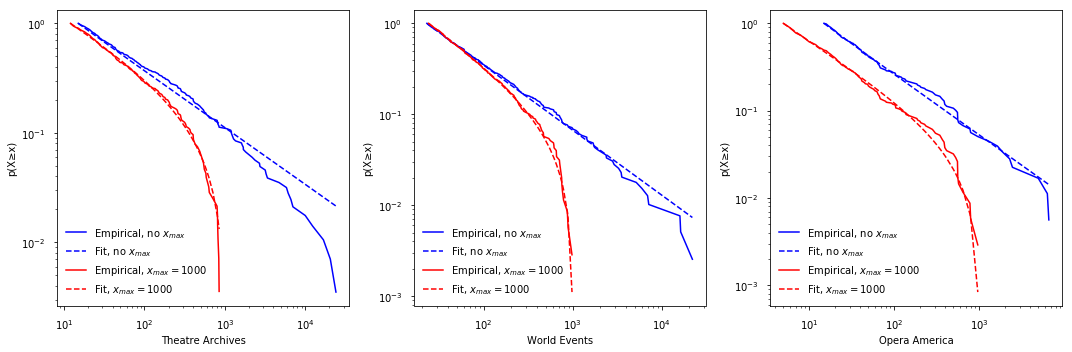

In [22]:
fig = plt.figure(figsize=(15, 5))

data = data_archives

plt.subplot(1, 3, 1)
fit = powerlaw.Fit(data, discrete=True, xmax=None)
FigCCDFmax = fit.plot_ccdf(color='b', label=r"Empirical, no $x_{max}$")
fit.power_law.plot_ccdf(color='b', linestyle='--', ax=FigCCDFmax, label=r"Fit, no $x_{max}$")
fit = powerlaw.Fit(data, discrete=True, xmax=1000)
fit.plot_ccdf(color='r', label=r"Empirical, $x_{max}=1000$")
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=FigCCDFmax, label=r"Fit, $x_{max}=1000$")

FigCCDFmax.set_ylabel(u"p(X≥x)")
FigCCDFmax.set_xlabel(r"Theatre Archives")
handles, labels = FigCCDFmax.get_legend_handles_labels()
leg = FigCCDFmax.legend(handles, labels, loc=3)
leg.draw_frame(False)

data = data_world

plt.subplot(1, 3, 2)
fit = powerlaw.Fit(data, discrete=True, xmax=None)
FigCCDFmax = fit.plot_ccdf(color='b', label=r"Empirical, no $x_{max}$")
fit.power_law.plot_ccdf(color='b', linestyle='--', ax=FigCCDFmax, label=r"Fit, no $x_{max}$")
fit = powerlaw.Fit(data, discrete=True, xmax=1000)
fit.plot_ccdf(color='r', label=r"Empirical, $x_{max}=1000$")
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=FigCCDFmax, label=r"Fit, $x_{max}=1000$")

FigCCDFmax.set_ylabel(u"p(X≥x)")
FigCCDFmax.set_xlabel(r"World Events")
handles, labels = FigCCDFmax.get_legend_handles_labels()
leg = FigCCDFmax.legend(handles, labels, loc=3)
leg.draw_frame(False)


data = data_us
plt.subplot(1, 3, 3)
fit = powerlaw.Fit(data, discrete=True, xmax=None)
FigCCDFmax = fit.plot_ccdf(color='b', label=r"Empirical, no $x_{max}$")
fit.power_law.plot_ccdf(color='b', linestyle='--', ax=FigCCDFmax, label=r"Fit, no $x_{max}$")
fit = powerlaw.Fit(data, discrete=True, xmax=1000)
fit.plot_ccdf(color='r', label=r"Empirical, $x_{max}=1000$")
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=FigCCDFmax, label=r"Fit, $x_{max}=1000$")

FigCCDFmax.set_ylabel(u"p(X≥x)")
FigCCDFmax.set_xlabel(r"Opera America")
handles, labels = FigCCDFmax.get_legend_handles_labels()
leg = FigCCDFmax.legend(handles, labels, loc=3)
leg.draw_frame(False)

plt.tight_layout()

figname = 'goodness_of_fit_composers'
savefig(figname+'.eps', bbox_inches='tight')

In [24]:
######################## Archive Sources  ########################
######################## CDF per source ########################

a_df = mdf.copy()
a_df = a_df[a_df['source_name'].isin(archival_sources)]
a_df = a_df.groupby(['work'])
a_df = a_df.agg({'performance_count': np.sum })
a_df = a_df.reset_index(level=['work'])
a_df = a_df.sort_values(by=['performance_count'], ascending=False)
a_df = a_df.reset_index() 
a_df = a_df.drop(columns=['index'])
a_df.index += 1
a_df = a_df.reset_index()
a_df = a_df.rename({'index': 'Ranking'}, axis='columns')
a_df.head()
data_archives = a_df['performance_count'].values

######################## WORLD           ########################

w_df = mdf.copy()
w_df = w_df[w_df['source_name'].isin(commercial_sources_world)]
w_df = w_df[w_df['year'] > 2007]
w_df = w_df[['composer', 'work', 'country', 'state', 'city', 'date_start', 'date_end', 'premiere_date', 'performance_count', 'year', 'decade', 'work_decade', 'composer_country']]
w_df = w_df.drop_duplicates()

w_df = w_df.groupby(['work'])
w_df = w_df.agg({'performance_count': np.sum })
w_df = w_df.reset_index(level=['work'])
w_df = w_df.sort_values(by=['performance_count'], ascending=False)
w_df = w_df.reset_index() 
w_df = w_df.drop(columns=['index'])
w_df.index += 1
w_df = w_df.reset_index()
w_df = w_df.rename({'index': 'Ranking'}, axis='columns')
w_df.head()
data_world = w_df['performance_count'].values
    
###############################################################

oa_df = mdf.copy()
oa_df = oa_df[oa_df['source_name'] == 'Opera America']
oa_df = oa_df.groupby(['work'])
oa_df = oa_df.agg({'performance_count': np.sum })
oa_df = oa_df.reset_index(level=['work'])
oa_df = oa_df.sort_values(by=['performance_count'], ascending=False)
oa_df = oa_df.reset_index() 
oa_df = oa_df.drop(columns=['index'])
oa_df.index += 1
oa_df = oa_df.reset_index()
oa_df = oa_df.rename({'index': 'Ranking'}, axis='columns')
oa_df.head()
data_us = oa_df['performance_count'].values
    
###############################################################

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


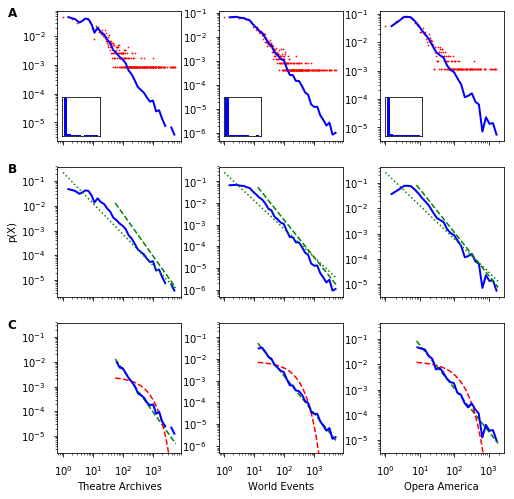

In [25]:
n_data = 3
n_graphs = 4
f = figure(figsize=(8,11))

data = data_archives
data_inst = 1
units = 'Theatre Archives'
plot_basics(data, data_inst, f, units)

data_inst = 2
data = data_world
units = 'World Events'
plot_basics(data, data_inst, f, units)

data = data_us
data_inst = 3
units = 'Opera America'
plot_basics(data, data_inst, f, units)

f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.3, hspace=.2)
figname = 'work_popularity'
f.savefig(figname+'.eps', bbox_inches='tight')
#f.savefig(figname+'.tiff', bbox_inches='tight', dpi=300)

Calculating best minimal value for power law fit
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


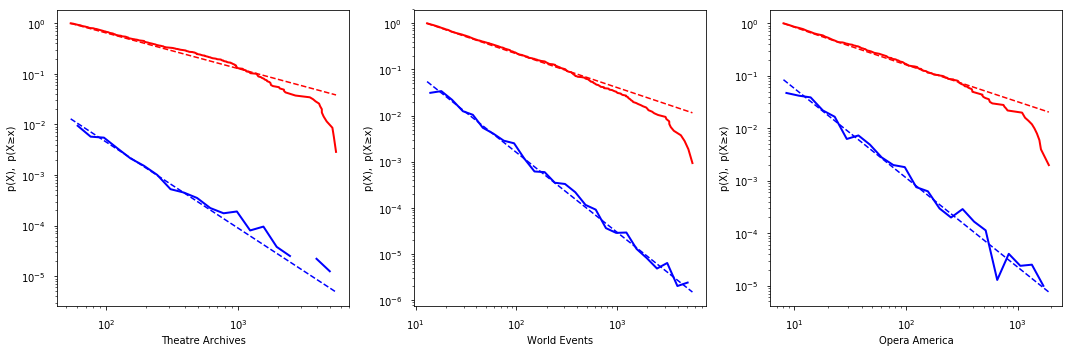

In [26]:
fig = plt.figure(figsize=(15, 5))

data = data_archives
fit = powerlaw.Fit(data, discrete=True)

plt.subplot(1, 3, 1)
figCCDF = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='b', linestyle='--', ax=figCCDF)
fit.plot_ccdf(color='r', linewidth=2, ax=figCCDF)
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=figCCDF)
figCCDF.set_ylabel(u"p(X),  p(X≥x)")
figCCDF.set_xlabel(r"Theatre Archives")

data = data_world
fit = powerlaw.Fit(data, discrete=True)

plt.subplot(1, 3, 2)
figCCDF = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='b', linestyle='--', ax=figCCDF)
fit.plot_ccdf(color='r', linewidth=2, ax=figCCDF)
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=figCCDF)
figCCDF.set_ylabel(u"p(X),  p(X≥x)")
figCCDF.set_xlabel(r"World Events")

data = data_us
fit = powerlaw.Fit(data, discrete=True)

plt.subplot(1, 3, 3)
figCCDF = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='b', linestyle='--', ax=figCCDF)
fit.plot_ccdf(color='r', linewidth=2, ax=figCCDF)
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=figCCDF)
figCCDF.set_ylabel(u"p(X),  p(X≥x)")
figCCDF.set_xlabel(r"Opera America")

plt.tight_layout()

figname = 'work_ccdf'
savefig(figname+'.eps', bbox_inches='tight')

Calculating best minimal value for power law fit
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/powerlaw.py:1185: RuntimeWarning: divide by zero encountered in double_scalars
  C = 1.0/C
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/optimize.py:543: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/powerlaw.py:830: RuntimeWarning: invalid val

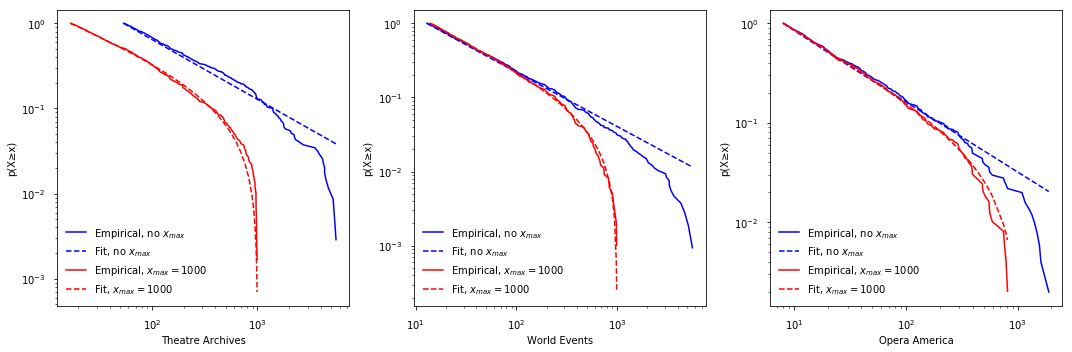

In [27]:
fig = plt.figure(figsize=(15, 5))

data = data_archives

plt.subplot(1, 3, 1)
fit = powerlaw.Fit(data, discrete=True, xmax=None)
FigCCDFmax = fit.plot_ccdf(color='b', label=r"Empirical, no $x_{max}$")
fit.power_law.plot_ccdf(color='b', linestyle='--', ax=FigCCDFmax, label=r"Fit, no $x_{max}$")
fit = powerlaw.Fit(data, discrete=True, xmax=1000)
fit.plot_ccdf(color='r', label=r"Empirical, $x_{max}=1000$")
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=FigCCDFmax, label=r"Fit, $x_{max}=1000$")

FigCCDFmax.set_ylabel(u"p(X≥x)")
FigCCDFmax.set_xlabel(r"Theatre Archives")
handles, labels = FigCCDFmax.get_legend_handles_labels()
leg = FigCCDFmax.legend(handles, labels, loc=3)
leg.draw_frame(False)

data = data_world

plt.subplot(1, 3, 2)
fit = powerlaw.Fit(data, discrete=True, xmax=None)
FigCCDFmax = fit.plot_ccdf(color='b', label=r"Empirical, no $x_{max}$")
fit.power_law.plot_ccdf(color='b', linestyle='--', ax=FigCCDFmax, label=r"Fit, no $x_{max}$")
fit = powerlaw.Fit(data, discrete=True, xmax=1000)
fit.plot_ccdf(color='r', label=r"Empirical, $x_{max}=1000$")
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=FigCCDFmax, label=r"Fit, $x_{max}=1000$")

FigCCDFmax.set_ylabel(u"p(X≥x)")
FigCCDFmax.set_xlabel(r"World Events")
handles, labels = FigCCDFmax.get_legend_handles_labels()
leg = FigCCDFmax.legend(handles, labels, loc=3)
leg.draw_frame(False)


data = data_us
plt.subplot(1, 3, 3)
fit = powerlaw.Fit(data, discrete=True, xmax=None)
FigCCDFmax = fit.plot_ccdf(color='b', label=r"Empirical, no $x_{max}$")
fit.power_law.plot_ccdf(color='b', linestyle='--', ax=FigCCDFmax, label=r"Fit, no $x_{max}$")
fit = powerlaw.Fit(data, discrete=True, xmax=1000)
fit.plot_ccdf(color='r', label=r"Empirical, $x_{max}=1000$")
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=FigCCDFmax, label=r"Fit, $x_{max}=1000$")

FigCCDFmax.set_ylabel(u"p(X≥x)")
FigCCDFmax.set_xlabel(r"Opera America")
handles, labels = FigCCDFmax.get_legend_handles_labels()
leg = FigCCDFmax.legend(handles, labels, loc=3)
leg.draw_frame(False)

plt.tight_layout()

figname = 'goodness_of_fit_works'
savefig(figname+'.eps', bbox_inches='tight')